In [1]:
!pip3 install celluloid
!pip3 install torchio
!pip3 install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 9.1 MB/s eta 0:00:00


In [2]:
# Commented out IPython magic to ensure Python compatibility.
# %matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [3]:

root = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr")
label = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr")

In [4]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object

sample_path = list(root.glob("liver*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

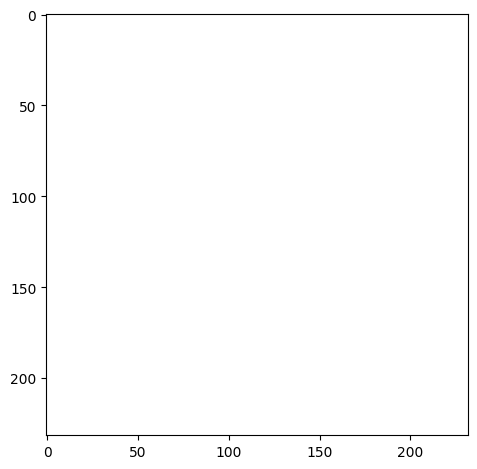

In [5]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)  # Class labels should not be handled as float64

nib.aff2axcodes(data.affine)

fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(ct.shape[2]):  # Axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    # plt.axis("off")
    camera.snap()  # Store the current slice
plt.tight_layout()
animation = camera.animate()  # Create the animation

HTML(animation.to_html5_video())

In [6]:
import torch
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv3d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv3d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Downsampling layers
        self.layer1 = DoubleConv(1, 32)  # Specify 1 input channel
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)

        # Upsampling layers
        self.layer5 = DoubleConv(256 + 128, 128)
        self.layer6 = DoubleConv(128 + 64, 64)
        self.layer7 = DoubleConv(64 + 32, 32)
        self.layer8 = torch.nn.Conv3d(32, 3, 1)  # Output segmentation classes

        self.maxpool = torch.nn.MaxPool3d(2)

    def forward(self, x):
        # Ensure input is 5D: [batch, channels, depth, height, width]
        if x.dim() == 4:
            x = x.unsqueeze(1)  # Add channel dimension if missing

        # Downsampling path
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Upsampling path
        x5 = torch.nn.functional.interpolate(x4, scale_factor=2, mode='trilinear', align_corners=False)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.functional.interpolate(x5, scale_factor=2, mode='trilinear', align_corners=False)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.functional.interpolate(x6, scale_factor=2, mode='trilinear', align_corners=False)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)
        return ret


model = UNet()

random_input = torch.randn(1, 1, 128, 128, 128)

with torch.no_grad():
    output = model(random_input)
assert output.shape == torch.Size([1, 3, 128, 128, 128])

In [7]:
from pathlib import Path
import json
import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

path = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)

for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

In [8]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})

train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

In [9]:
def custom_collate(batch):
    # Add channel dimension (unsqueeze)
    ct_tensors = torch.stack([subject['CT'][tio.DATA].squeeze(0).unsqueeze(0) for subject in batch])
    label_tensors = torch.stack([subject['Label'][tio.DATA].squeeze(0).unsqueeze(0) for subject in batch])
    
    return {
        'CT': ct_tensors,
        'Label': label_tensors
    }

In [10]:

batch_size = 2

train_loader = torch.utils.data.DataLoader(
    train_patches_queue, 
    batch_size=batch_size, 
    num_workers=0,
    collate_fn=custom_collate,
    pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    val_patches_queue, 
    batch_size=batch_size, 
    num_workers=0,
    collate_fn=custom_collate,
    pin_memory=False
)


class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.loss_history = {'train': [], 'val': []}

    def training_step(self, batch, batch_idx):
        img = batch['CT']
        mask = batch['Label'][:,0].long()

        pred = self.model(img)
        loss = self.loss_fn(pred, mask)
        self.loss_history['train'].append(loss.item())
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss

    def validation_step(self, batch, batch_idx):
        img = batch['CT']
        mask = batch['Label'][:,0].long()

        pred = self.model(img)
        loss = self.loss_fn(pred, mask)
        self.loss_history['val'].append(loss.item())
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        return loss
        
    def on_train_epoch_end(self):
        # Save loss history to JSON file at the end of training epoch
        with open('/kaggle/working/train_history.json', 'w') as f:
            json.dump(self.loss_history, f)

    def on_validation_epoch_end(self):
        # Save loss history to JSON file at the end of validation epoch
        with open('/kaggle/working/val_history.json', 'w') as f:
            json.dump(self.loss_history, f)

    def log_images(self, img, pred, mask, name):

        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

# Instanciate the model
model = Segmenter()

In [11]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=1,
    mode='min')
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="/kaggle/working/logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)

# Train the model.
# This might take some hours depending on your GPU
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
import os
print(os.listdir("/kaggle/working/logs/lightning_logs/version_0/checkpoints"))

['epoch=28-step=7627.ckpt']


In [14]:

import shutil

source_path = '/kaggle/working/logs/lightning_logs/version_0/checkpoints/epoch=28-step=7627.ckpt'
destination_path = '/kaggle/working/epoch=28-step=7627.ckpt'

shutil.copyfile(source_path, destination_path)

'/kaggle/working/epoch=28-step=7627.ckpt'

In [23]:
import torch
import torchio as tio
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Load the model
lightning_model = Segmenter.load_from_checkpoint("/kaggle/working/logs/lightning_logs/version_0/checkpoints/epoch=28-step=7627.ckpt")
model = lightning_model.model  # Extract the underlying UNet model
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

def save_prediction_as_nii(model, dataset, idx, output_path):
    """
    Save model prediction as a NIfTI file and generate a visualization
    
    Args:
    - model: Trained segmentation model
    - dataset: TorchIO dataset
    - idx: Index of the subject to predict
    - output_path: Path to save the NIfTI file
    """
    # Select the subject
    subject = dataset[idx]
    
    # Original image and mask for reference
    original_img = subject["CT"]["data"]
    mask = subject["Label"]["data"]
    
    # GridSampler
    grid_sampler = tio.inference.GridSampler(subject, 96, (8, 8, 8))
    
    # GridAggregator
    aggregator = tio.inference.GridAggregator(grid_sampler)
    
    # DataLoader for speed up
    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)
    
    # Prediction
    with torch.no_grad():
        for patches_batch in patch_loader:
            input_tensor = patches_batch['CT']["data"].to(device)
            
            # Ensure input is 5D: [batch, channels, depth, height, width]
            if input_tensor.dim() == 4:
                input_tensor = input_tensor.unsqueeze(1)
            
            locations = patches_batch[tio.LOCATION]
            pred = model(input_tensor)
            aggregator.add_batch(pred.cpu(), locations)
    
    # Extract the volume prediction
    output_tensor = aggregator.get_output_tensor()
    pred = output_tensor.argmax(0).numpy()
    
    # Create NIfTI image using the original image affine and header
    original_nii = nib.load(str(subject["CT"].path))
    nii_pred = nib.Nifti1Image(pred.astype(np.uint8), 
                                original_nii.affine, 
                                original_nii.header)
    
    # Save the prediction
    nib.save(nii_pred, output_path)
    
    # Visualization as image stack
    visualization_dir = os.path.join(os.path.dirname(output_path), "visualization")
    os.makedirs(visualization_dir, exist_ok=True)
    
    # Create image stack for visualization
    image_paths = []
    for i in range(0, pred.shape[2], 2):  # axial view
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img[0,:,:,i], cmap="bone")
        plt.title(f"Original CT Slice {i}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(original_img[0,:,:,i], cmap="bone")
        mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
        plt.imshow(mask_, alpha=0.3, cmap="autumn")
        plt.title(f"Prediction Slice {i}")
        
        # Save the figure
        image_path = os.path.join(visualization_dir, f"slice_{i:03d}.png")
        plt.savefig(image_path)
        image_paths.append(image_path)
        plt.close()
    
    # Create GIF
    gif_path = os.path.join(os.path.dirname(output_path), "prediction_visualization.gif")
    images = []
    for filename in image_paths:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images, duration=0.5)
    
    print(f"Visualization GIF saved to {gif_path}")
    
    return nii_pred, gif_path

# Usage
IDX = 4  # Choose the subject index
output_path = "/kaggle/working/prediction.nii"

# Save prediction and get visualization
prediction_nii, gif_path = save_prediction_as_nii(model, val_dataset, IDX, output_path)

print(f"Prediction saved to {output_path}")
print(f"Visualization available at {gif_path}")

Visualization GIF saved to /kaggle/working/prediction_visualization.gif
Prediction saved to /kaggle/working/prediction.nii
Visualization available at /kaggle/working/prediction_visualization.gif


In [29]:
import numpy as np

# Detailed array information
print("Prediction array details:")
pred_np = prediction_nii.get_fdata()
print("Full prediction shape:", pred_np.shape)
print("Prediction dtype:", pred_np.dtype)
print("Prediction min/max:", pred_np.min(), pred_np.max())

print("\nMask array details:")
mask_np = mask[0]
print("Full mask shape:", mask_np.shape)
print("Mask dtype:", mask_np.dtype)
print("Mask min/max:", mask_np.min(), mask_np.max())

Prediction array details:
Full prediction shape: (256, 256, 200)
Prediction dtype: float64
Prediction min/max: 0.0 2.0

Mask array details:
Full mask shape: (232, 200)
Mask dtype: int64
Mask min/max: 0 0


In [30]:
import numpy as np

# Extract prediction and mask
pred_np = prediction_nii.get_fdata()
mask_np = mask[0]

# Threshold the prediction
pred_binary = (pred_np > 0.5).astype(np.float32)

# If mask is 2D and prediction is 3D, you might want to:
# 1. Select a specific slice or 
# 2. Compute Dice score across all slices

# Option 1: Compute Dice score slice by slice and average
dice_scores = []

for z in range(pred_binary.shape[2]):
    # Take the 2D slice from prediction
    pred_slice = pred_binary[:, :, z]
    
    # Option A: If you want to crop the prediction slice to match mask dimensions
    mid_x = pred_slice.shape[0] // 2
    start_x = mid_x - (mask_np.shape[0] // 2)
    end_x = start_x + mask_np.shape[0]
    
    pred_slice_cropped = pred_slice[start_x:end_x, :mask_np.shape[1]]
    
    # Convert to binary if not already
    pred_slice_binary = (pred_slice_cropped > 0.5).astype(np.float32)
    mask_slice_binary = (mask_np > 0).astype(np.float32)
    
    # Compute Dice score for this slice
    intersection = np.sum(pred_slice_binary * mask_slice_binary)
    union = np.sum(pred_slice_binary) + np.sum(mask_slice_binary)
    
    if union > 0:
        dice_score = 2 * intersection / union
        dice_scores.append(dice_score)

# Average Dice score across slices
average_dice_score = np.mean(dice_scores)
print("Average Dice Score:", average_dice_score)

Average Dice Score: 0.0
